24. UCI上的三个机器学习任务

24.1 鸢尾花数据集分类任务

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

In [2]:
with open("../input/ucl-iris/iris.data", "r") as f:
    lines = f.readlines()

查看文档与数据格式

In [3]:
x = np.empty(shape=(150,4),dtype="float")
y = np.empty(shape=150, dtype="int")

name_dict = {"Iris-setosa":0, "Iris-versicolor":1, "Iris-virginica":2}
feature_dict = {0:"sepal length", 1:"sepal width", 2:"petal length", 3:"petal width"}
for i in range(len(lines)-1):
    s = lines[i]
    l = s.split(',')
    x[i] = [float(a) for a in l[:4]]
    y[i] = name_dict[l[4].strip('\n')]


文档中提及，花瓣的长度和宽度与花的种类有很强的相关性，以这两个特征绘制散点图

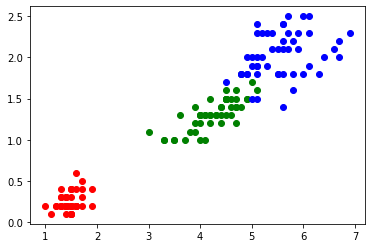

In [4]:
for i in range(len(x)):
    if y[i] == 0:
        plt.scatter(x[i][2],x[i][3],color='r')
    elif y[i] == 1:
        plt.scatter(x[i][2],x[i][3],color='g')
    elif y[i] == 2:
        plt.scatter(x[i][2],x[i][3],color='b')
plt.show()

由于数据在原空间年内并非线性可分，采用逻辑斯特回归

观察到三种花区分度较高，对每一对鸢尾花种类都产生一个分类器，也即产生三个分类器，最终采用投票预测方法

In [5]:
#定义逻辑斯特回归模型
class LogisticModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(4,1)
    def forward(self,x):
        return torch.sigmoid(self.linear(x))
    
class LogisticClassifier():
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.1
        self.epoch = 5000
        self.model = LogisticModel()
        self.criterion = torch.nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate) 
        
    def train(self,X,Y):
        x = torch.Tensor(X)
        y = torch.Tensor(Y).reshape(-1,1)
        for e in range(self.epoch):
            pred = self.model(x)
            loss = self.criterion(pred,y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if e % 1000 == 0:
                print("epoch:{}, loss:{}".format(e, loss.data))
    
    def test(self,X,a,b):
        x = torch.Tensor(X)
        with torch.no_grad():
            y = self.model(x)
        pred = np.empty(y.shape,dtype="int")
        for i in range(len(pred)):
            if y[i] > 0.5:
                pred[i] = a
            else:
                pred[i] = b
        return pred

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

C01 = LogisticClassifier()
C02 = LogisticClassifier()
C12 = LogisticClassifier()

def generate(a,b):
    #输入种类a，b，抽取出A-B二分类器需要的正反例数据
    x = []
    y = []
    for i in range(len(xtrain)):
        if ytrain[i] == a:
            x.append(xtrain[i])
            y.append(1)
        elif ytrain[i] == b:
            x.append(xtrain[i])
            y.append(0)
    return x,y


x,y = generate(0,1)
C01.train(x,y)
x,y = generate(0,2)
C02.train(x,y)
x,y = generate(1,2)
C12.train(x,y)

epoch:0, loss:1.0394037961959839
epoch:1000, loss:0.007556920405477285
epoch:2000, loss:0.0039921593852341175
epoch:3000, loss:0.002755723660811782
epoch:4000, loss:0.002119962126016617
epoch:0, loss:0.7498001456260681
epoch:1000, loss:0.00383496074937284
epoch:2000, loss:0.0019435225985944271
epoch:3000, loss:0.001306855701841414
epoch:4000, loss:0.0009863224113360047
epoch:0, loss:1.2368155717849731
epoch:1000, loss:0.18460850417613983
epoch:2000, loss:0.14864574372768402
epoch:3000, loss:0.13451246917247772
epoch:4000, loss:0.1266985386610031


预测测试集上的结果，输出储存投票结果vote矩阵发现并未出现三种花平票的情况

In [7]:
votes = np.zeros(3)

vote1 = C01.test(xtest,0,1).reshape(-1)
vote2 = C02.test(xtest,0,2).reshape(-1)
vote3 = C12.test(xtest,1,2).reshape(-1)
v = np.stack((vote1,vote2,vote3),axis=1)

pred = np.empty(len(v),dtype="int")
for i in range(len(v)):
    c = np.bincount(v[i])
    arg = np.argmax(c)
    pred[i] = arg

print(pred==ytest)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


预测结果很好，准确率达到100%

24.2 葡萄酒数据集

数据集为三种不同葡萄酒的酒精含量等特征，对应于三分类问题，采用三个逻辑斯特回归模型

每次将其他种类的葡萄酒作为负样例，该种类作为正样例，每个模型输出对应葡萄酒种类的概率

对数据进行预处理，采用标准化，证明有无预处理效果差距很大

在没有进行标准化时，损失函数很难下降，但预处理后下降明显


In [8]:
class LogisticModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(13,1)
    def forward(self,x):
        return torch.sigmoid(self.linear(x))
    
class LogisticClassifier():
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.03
        self.epoch = 10000
        self.model = LogisticModel()
        self.criterion = torch.nn.BCELoss()
        self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr=self.learning_rate) 
        
    def train(self,X,Y):
        x = torch.Tensor(X)
        y = torch.Tensor(Y).reshape(-1,1)
        for e in range(self.epoch):
            pred = self.model(x)
            loss = self.criterion(pred,y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if e % 1000 == 0:
                print("epoch:{}, loss:{}".format(e, loss.data))
    
    def test(self,X):
        x = torch.Tensor(X)
        with torch.no_grad():
            y = self.model(x)
        return y

#读取数据
x = []
y = []
for s in open("../input/ucl-wine/wine.data", "r"):
    s = s.replace('\n','')
    l = s.split(',')
    y.append(int(l[0]))
    x.append([float(x) for x in l[1:]])

#特征标准化
x = np.array(x, dtype="float")
y = np.array(y, dtype="int")
x -= np.mean(x,axis=0)
x /= np.std(x,axis=0)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

Wine1 = LogisticClassifier()
Wine2 = LogisticClassifier()
Wine3 = LogisticClassifier()

def generate(a):
    #输入葡萄酒的种类a，将其他种类的葡萄酒设置为负样例，标签值设置为0
    x = []
    y = []
    for i in range(len(xtrain)):
        if ytrain[i] == a:
            x.append(xtrain[i])
            y.append(1)
        else:
            x.append(xtrain[i])
            y.append(0)
    return x,y


x,y = generate(1)
Wine1.train(x,y)
x,y = generate(2)
Wine2.train(x,y)
x,y = generate(3)
Wine3.train(x,y)

#由概率值预测葡萄酒的种类
prob1 = Wine1.test(xtest).reshape(-1)
prob2 = Wine2.test(xtest).reshape(-1)
prob3 = Wine3.test(xtest).reshape(-1)
prob = np.stack((prob1,prob2,prob3),axis=1)
pred = np.argmax(prob,axis=1)+1
print(pred==ytest)

epoch:0, loss:0.6326785683631897
epoch:1000, loss:0.05629235878586769
epoch:2000, loss:0.036069393157958984
epoch:3000, loss:0.027352377772331238
epoch:4000, loss:0.022315219044685364
epoch:5000, loss:0.018977554515004158
epoch:6000, loss:0.0165802463889122
epoch:7000, loss:0.014763683080673218
epoch:8000, loss:0.01333353016525507
epoch:9000, loss:0.012174760922789574
epoch:0, loss:0.7335184812545776
epoch:1000, loss:0.10480141639709473
epoch:2000, loss:0.07624847441911697
epoch:3000, loss:0.06305144727230072
epoch:4000, loss:0.05492452532052994
epoch:5000, loss:0.049221254885196686
epoch:6000, loss:0.04490749537944794
epoch:7000, loss:0.04148265719413757
epoch:8000, loss:0.03866995498538017
epoch:9000, loss:0.03630165010690689
epoch:0, loss:0.8460639119148254
epoch:1000, loss:0.08238323777914047
epoch:2000, loss:0.05382785201072693
epoch:3000, loss:0.04145408421754837
epoch:4000, loss:0.03431401774287224
epoch:5000, loss:0.02958131767809391
epoch:6000, loss:0.02617395669221878
epoch:7

多次实验，每次实验几乎都发现存在1个很难正确分类的样本，其他大部分样本分类结果均正确，准确率约为98.12%

24.3 人类数据集

任务为预测人的体重是否大于50kg，输入为不同人的体重信息和各种其他信息，对应二分类问题

由于数据涉及离散型特征，将离散型特征用独热向量编码，连续型特征作标准化处理

In [9]:
x1 = []
x2 = []
y = []
cont_indexs = [0,2,4,10,11,12]
scat_indexs = [1,3,5,6,7,8,9,13]
for s in open("../input/ucl-adult/adult.data", "r"):
    s = s.replace('\n','')
    s = s.replace(' ','')
    l = s.split(',')
    if len(l) != 15:
        continue
    if l[-1] == ">50K":
        y.append(1)
    elif l[-1] == "<=50K":
        y.append(0)
    else:
        print(l[-1])
    #将连续特征存入x1,离散特征存入x2
    x1.append([l[i] for i in cont_indexs])
    x2.append([l[i] for i in scat_indexs])

x1 = np.array(x1,dtype="float")
x1 -= np.mean(x1,axis=0)
x1 /= np.std(x1,axis=0)
#对连续型数据进行标准化

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
x2 = encoder.fit_transform(x2)
x2 = np.array(x2,dtype="int")
#将离散型特征用onehot编码后得到长度为102的独热向量

x = np.concatenate((x1,x2),axis=1)
#得到特征维度108

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

#模型定义
class LogisticModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(108,1)
    def forward(self,x):
        return torch.sigmoid(self.linear(x))
    
class LogisticClassifier():
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.1
        self.epoch = 3500
        self.model = LogisticModel()
        self.criterion = torch.nn.BCELoss()
        self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr=self.learning_rate) 
        
    def train(self,X,Y):
        x = torch.Tensor(X)
        y = torch.Tensor(Y).reshape(-1,1)
        for e in range(self.epoch):
            pred = self.model(x)
            loss = self.criterion(pred,y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if e % 1000 == 0:
                print("epoch:{}, loss:{}".format(e, loss.data))
    
    def test(self,X):
        x = torch.Tensor(X)
        with torch.no_grad():
            y = self.model(x)
        pred = [a>0.5 for a in y]
        return np.array(pred,dtype="int")

Adult = LogisticClassifier()
Adult.train(xtrain,ytrain)
pred = Adult.test(xtest)
print(sum(pred==ytest))
accuracy = sum(pred==ytest) / len(ytest)
print("accuracy: ", accuracy)

epoch:0, loss:0.7003549337387085
epoch:1000, loss:0.3153149485588074
epoch:2000, loss:0.3151177763938904
epoch:3000, loss:0.31503188610076904
8326
accuracy:  0.8522878493192753


分类准确率为85%